# Funkcje pomocnicze

In [ ]:
!pip install pyabc==0.10.10
!git clone https://github.com/JuliaZur/TumorGrowthModel.git

In [2]:
import numpy as np
import pandas as pd
import pyabc
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tempfile
from collections import Counter

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [125]:
def plot_history(history):
    _, arr_ax = plt.subplots(2, 2)

    pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
    pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
    pyabc.visualization.plot_credible_intervals(
        history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
        show_mean=True, show_kde_max_1d=True, arr_ax=arr_ax[1][0])
    pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

    plt.gcf().set_size_inches((12, 8))
    plt.gcf().tight_layout()

def plot_comparison(mu, sigma):
    simulation = gaussian_simulation({'mu': mu, 'sigma': sigma})['data']
    fig, ax = plt.subplots(1, 1)
    ax.hist(simulation, density=True, histtype='stepfilled', alpha=0.5, label='model')
    ax.hist(data, density=True, histtype='stepfilled', alpha=0.5, label='data')
    ax.legend(loc='best', frameon=False)
    plt.show()

def plot_double_comparison(mu_1, sigma_1, mu_2, sigma_2, f_h_samples):
    simulation = double_gaussian_simulation({
        'mu_1': mu_1,
        'sigma_1': sigma_1,
        'mu_2': mu_2,
        'sigma_2': sigma_2,
        'f_h_samples': f_h_samples
    })['data']
    sim_hist = get_hist(simulation)
    data_hist = get_hist(double_data)
    fig, ax = plt.subplots(1, 1)
    ax.bar(possible_keys, sim_hist, label="model", alpha=0.5)
    ax.bar(possible_keys, data_hist, label="data", alpha=0.5)
    ax.legend(loc='best', frameon=False)
    plt.show()
    
def plot_posterior(history, name):
    if name == 'danceability':
        mu_min, mu_max = 0, 1.5
        sigma_min, sigma_max = 0, 1.5
    elif name == 'loudness':
        mu_min, mu_max = -10, -2.5
        sigma_min, sigma_max = 1.5, 4.5
    else:
        mu_min, mu_max = -10, 10
        sigma_min, sigma_max = 0, 10
    fig = plt.figure(figsize=(15, 10))
    ax_mu = fig.add_subplot(221)
    for t in range(history.max_t+1):
        df_h, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df_h, w,
            xmin=mu_min, xmax=mu_max,
            x="mu", ax=ax_mu,
            label="t={}".format(t))
    ax_mu.legend();
    ax_sigma = fig.add_subplot(222)
    for t in range(history.max_t+1):
        df_h, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df_h, w,
            xmin=sigma_min, xmax=sigma_max,
            x="sigma", ax=ax_sigma,
            label="t={}".format(t))
    ax_sigma.legend();

# Dane
Informacje o piosenkach w serwisie Spotify:

https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify?select=genres_v2.csv

In [9]:
df = pd.read_csv('TumorGrowthModel/data/genres.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


# Algorytm ABC-SMC

# --------------------------------------------------------
# TU DZIOBAK WRZUCA SWOJĄ SUPER CZĘŚĆ
# --------------------------------------------------------

# ABS-SMC przy użyciu biblioteki pyABC

## Dopasowanie modelu Gaussa do danych

In [69]:
def get_stats(data):
    return np.array([data.mean(), data.std()])

def distance(simulation, data):
    data_stats = get_stats(data["data"])
    simulation_stats = get_stats(simulation["data"])
    return np.mean(abs(simulation_stats - data_stats))

In [70]:
def gaussian_simulation(parameters):
    return {"data": st.norm.rvs(loc=parameters['mu'], scale=parameters['sigma'], size=n_samples)}

In [93]:
data, data_name = np.array(df.danceability), 'danceability'
# data, data_name = np.array(df.loudness), 'loudness
n_samples = data.shape[0]

data_mu = data.mean()
data_sigma = data.std()

print(
    f'''
    DATA:
    \t mu: \t\t{data_mu}
    \t sigma: \t{data_sigma}
    '''
)


    DATA:
    	 mu: 		0.6393643210022456
    	 sigma: 	0.1566152732579436
    


In [94]:
# ---- DANCEABILITY ----
# eps = 0.1 (0.01 also wokrs t ~ 9)
danceability_parameter_priors = [
    pyabc.Distribution(
        mu=pyabc.RV("uniform", 0.1, 0.9),
        sigma=pyabc.RV("uniform", 0.1, 0.9),
                      )
]

# ---- LOUDNESS ----
# eps = 0.1 with t ~ 8

loudness_parameter_priors = [
    pyabc.Distribution(
        mu=pyabc.RV("uniform", -10, 10),
        sigma=pyabc.RV("uniform", 0.1, 5),
                      )
]

In [95]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "tutorial.db"))
abc = pyabc.ABCSMC(gaussian_simulation, danceability_parameter_priors, distance)
abc.new(db_path, {"data": data});

INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=7, start_time=2021-01-10 18:06:41.913043, end_time=None)>


In [96]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.3015981744702136
INFO:ABC:t: 0, eps: 0.3015981744702136.
INFO:ABC:Acceptance rate: 100 / 205 = 4.8780e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.2049554615437449.
INFO:ABC:Acceptance rate: 100 / 166 = 6.0241e-01, ESS=9.5060e+01.
INFO:ABC:t: 2, eps: 0.147193723673748.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=9.2941e+01.
INFO:ABC:t: 3, eps: 0.10286822414870715.
INFO:ABC:Acceptance rate: 100 / 201 = 4.9751e-01, ESS=9.0044e+01.
INFO:ABC:t: 4, eps: 0.06382062745174202.
INFO:ABC:Acceptance rate: 100 / 201 = 4.9751e-01, ESS=9.3929e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=7, start_time=2021-01-10 18:06:41.913043, end_time=2021-01-10 18:06:51.696599)>


In [97]:
mu = float(history.get_distribution()[0].tail(1).mu)
sigma = float(history.get_distribution()[0].tail(1).sigma)
print(
    f'''
    MODEL:
    \t mu: \t\t{mu}
    \t sigma: \t{sigma}
    DATA:
    \t mu: \t\t{data_mu}
    \t sigma: \t{data_sigma}
    '''
)


    MODEL:
    	 mu: 		0.6612839533013914
    	 sigma: 	0.1724422194704397
    DATA:
    	 mu: 		0.6393643210022456
    	 sigma: 	0.1566152732579436
    


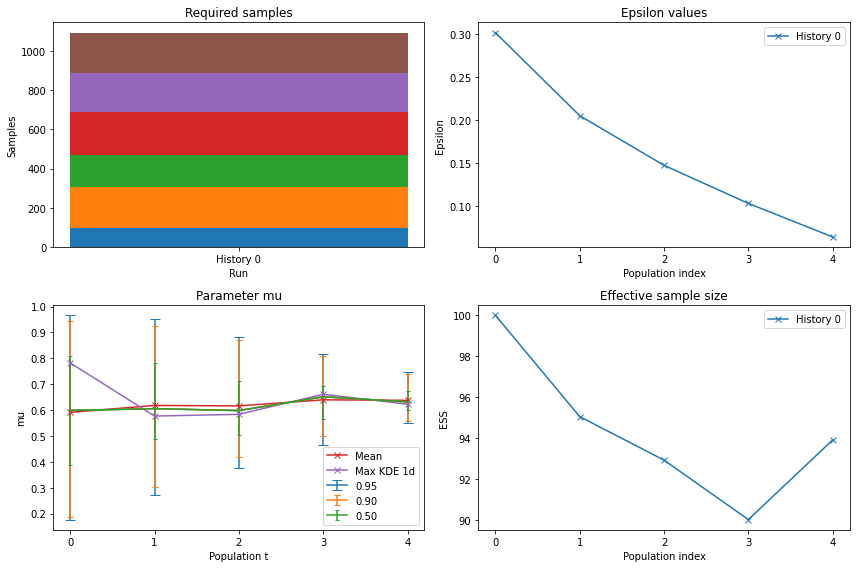

In [98]:
plot_history(history)

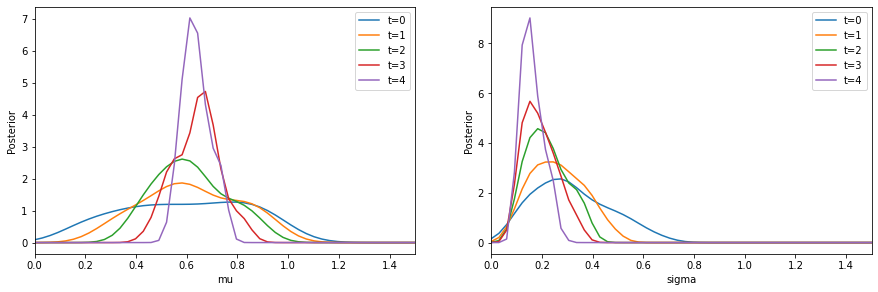

In [99]:
plot_posterior(history, data_name)

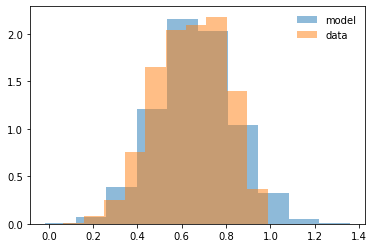

In [101]:
plot_comparison(mu, sigma)

## Gauss z dwoma "górkami"

<AxesSubplot:xlabel='key', ylabel='count'>

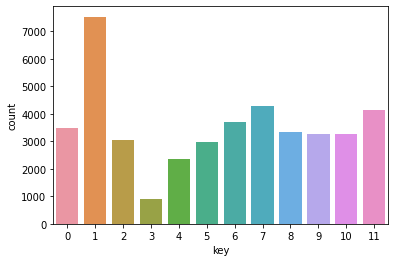

In [102]:
sns.countplot(x="key", data=df)

In [103]:
hists = []
def get_hist(data):
    c = Counter(data)
    hist = []
    for key in possible_keys:
        hist.append(c.get(key, 0))
    return np.array(hist)

def double_distance(simulation, data):
    data_stats = get_hist(data["data"])
    simulation_stats = get_hist(simulation["data"])
    hists.append({'sim': simulation_stats, 'data': data_stats})
    return np.mean(abs(simulation_stats - data_stats))

In [104]:
def double_gaussian_simulation(parameters):
    second_heap_samples = n_double_samples - int(parameters['f_h_samples'])
    h1 = st.norm.rvs(loc=parameters['mu_1'], scale=parameters['sigma_1'], size=int(parameters['f_h_samples']))
    h2 = st.norm.rvs(loc=parameters['mu_2'], scale=parameters['sigma_2'], size=second_heap_samples)
    h1 = [max(0, min(int(h), possible_keys[-1])) for h in h1]
    h2 = [max(0, min(int(h), possible_keys[-1])) for h in h2]

    data = np.hstack([h1, h2])
#     data = [int(d) for d in data]

    return {"data": data}

In [105]:
double_data = np.array(df.key)
n_double_samples = double_data.shape[0]
possible_keys = sorted(df.key.unique())

print(
    f'''
    DATA:
    \t mu_1: \t\t~ 1
    \t sigma_1: \t~ 1
    \t mu_2: \t\t~ 7
    \t sigma_2: \t~ 3
    '''
)


    DATA:
    	 mu_1: 		~ 1
    	 sigma_1: 	~ 1
    	 mu_2: 		~ 7
    	 sigma_2: 	~ 3
    


In [107]:
# ---- KEY ----
# eps = 1000 t ~ 9
# eps = 900 t ~ 10
key_parameter_priors = [
    pyabc.Distribution(
        mu_1=pyabc.RV("uniform", 0, 4),
        sigma_1=pyabc.RV("uniform", 0, 3),
        mu_2=pyabc.RV("uniform", 3, 10),
        sigma_2=pyabc.RV("uniform", 0, 6),
        f_h_samples=pyabc.RV("uniform", 0, n_double_samples)
                      )
]


In [127]:
abc = pyabc.ABCSMC(double_gaussian_simulation, key_parameter_priors, double_distance)
abc.new(db_path, {"data": double_data});

INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=10, start_time=2021-01-10 18:25:15.113910, end_time=None)>


In [128]:
history = abc.run(minimum_epsilon=700, max_nr_populations=15)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 3104.7499999999977
INFO:ABC:t: 0, eps: 3104.7499999999977.
INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 2443.083333333333.
INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.9282e+01.
INFO:ABC:t: 2, eps: 1949.526550435046.
INFO:ABC:Acceptance rate: 100 / 258 = 3.8760e-01, ESS=7.0533e+01.
INFO:ABC:t: 3, eps: 1671.3174175337338.
INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=3.3563e+01.
INFO:ABC:t: 4, eps: 1476.2048920735938.
INFO:ABC:Acceptance rate: 100 / 275 = 3.6364e-01, ESS=4.1765e+01.
INFO:ABC:t: 5, eps: 1326.7938893454743.
INFO:ABC:Acceptance rate: 100 / 255 = 3.9216e-01, ESS=6.2662e+01.
INFO:ABC:t: 6, eps: 1212.5479772455985.
INFO:ABC:Acceptance rate: 100 / 270 = 3.7037e-01, ESS=5.0514e+01.
INFO:ABC:t: 7, eps: 1108.4006895552045.
INFO:ABC:Acceptance rate: 100 / 359 = 2.7855e-01, ESS=5.4182e+01.
INFO:ABC:t: 8, eps: 1039.40749603731.
INFO:ABC:Acceptance rate:

In [129]:
mu_1 = float(history.get_distribution()[0].tail(1).mu_1)
sigma_1 = float(history.get_distribution()[0].tail(1).sigma_1)

mu_2 = float(history.get_distribution()[0].tail(1).mu_2)
sigma_2 = float(history.get_distribution()[0].tail(1).sigma_2)

f_h_samples = float(history.get_distribution()[0].tail(1).f_h_samples)
print(
    f'''
    MODEL:
    \t mu_1: \t\t{mu_1}
    \t sigma_1: \t{sigma_1}
    \t mu_2: \t\t{mu_2}
    \t sigma_2: \t{sigma_2}
    \t f_h_samples: \t{f_h_samples}
    '''
)


    MODEL:
    	 mu_1: 		1.7214054468345414
    	 sigma_1: 	0.41340195317583933
    	 mu_2: 		7.461437601774429
    	 sigma_2: 	3.074963549071191
    	 f_h_samples: 	11828.98112973221
    


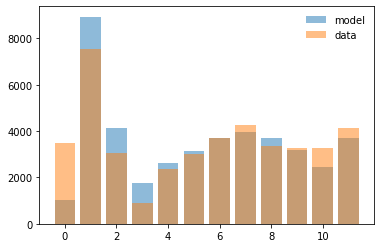

In [130]:
plot_double_comparison(mu_1, sigma_1, mu_2, sigma_2, f_h_samples)